# MIDA
## Multiple Imputation Model

In [1]:
# import libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import layers, Model,metrics, losses, optimizers, callbacks
from tensorflow.keras.models import load_model
import numpy as np
import warnings
warnings.filterwarnings('ignore') #to avoid some ugly warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import figure
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
#tf.random.set_seed(1234)
from tqdm import tqdm
tf.autograph.set_verbosity(1)
import logging
import os
import shutil
# disable logging messages by tf
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# set seed
tf.random.set_seed(987)

In [2]:
class clean_data(object):
    '''
    CLASS clean_data()

    It performs missing value detection for all the datasets, filling them with:

        - mean for features with continuous variables;

        - most frequent label for features with categorical variables.

    Then it converts categorical string variables, in categorical numbers, in order to let data be easly processed by the model.
    
    It takes as inputs, the 15 datasets.
    '''
    def __init__(self):
        self.bh_df = pd.read_csv('data/bh.csv', index_col=0)
        self.bc_df = pd.read_csv('data/bc.csv', index_col=0)
        self.dn_df = pd.read_csv('data/dna.csv', index_col=0)
        self.gl_df = pd.read_csv('data/gl.csv', index_col=0)
        self.hv_df = pd.read_csv('data/hv.csv', index_col=0)
        self.is_df = pd.read_csv('data/is.csv', index_col=0)
        self.on_df = pd.read_csv('data/on.csv', index_col=0)
        self.sl_df = pd.read_csv('data/sl.csv', index_col=0)
        self.sr_df = pd.read_csv('data/sr.csv', index_col=0)
        self.st_df = pd.read_csv('data/st.csv', index_col=0)
        self.sn_df = pd.read_csv('data/sn.csv', index_col=0)
        self.sb_df = pd.read_csv('data/sb.csv', index_col=0)
        self.vc_df = pd.read_csv('data/vc.csv', index_col=0)
        self.vw_df = pd.read_csv('data/vw.csv', index_col=0)
        self.zo_df = pd.read_csv('data/zo.csv')
        
    @staticmethod
    def class_replacing(df, column, binary):
        '''
        Inputs:
            - dataframe df;
            
            - column: feature name;
            
            - binary: Boolean.
        Output:
            - df with feature values replaced with numbers from 1,..,etc. (IF binary = False).
            
            OR
            
            - df with feature values replaced by 0-1 (IF binary = True).
        '''
        
        if not binary:
            class_values = list(set(df[column]))
            for i in range(len(class_values)):
                df[column][df[column] == class_values[i]] = i+1
        else:
            class_values = list(set(df[column]))
            for i in range(len(class_values)):
                df[column][df[column] == class_values[i]] = i
        return df
        
        
    @staticmethod
    def missing_values(df):
        '''
        Inputs:
            - dataframe.
        Outputs:
            - histogram with missing value distribution divided by feature.
        '''
        # isnull() return the df with True if corresponding value is missing, otherwise False.
        # sum() return for each col label, the sum of tot missing values.
        # sort_values(..) to sort df by descending order of values.
        total = df.isnull().sum().sort_values(ascending = False)

        # percent return df sorted by descent order of values.
        # for each column label of the original df gives the percentage of missing values (n miss value/n tot value).
        percent = (df.isnull().sum()/len(df)*100).sort_values(ascending = False)

        # return df that is concatenation of total and percent dfs.
        ms =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

        # consider just ms with percent of missing values > 0.
        ms =ms[ms.Percent>0]
        
        #plot of percentages.
        
        sns.set(style="whitegrid")
        #plt.figure(figsize=(9, 6))
        #plt.subplot(2, 1, 1)
        ax = sns.barplot(x=np.asarray(ms.index),y="Percent",data=ms, alpha = 0.8)
        plt.xticks(rotation=55)
        #ax.set_ylim(0,100)
        #plt.hist(ms)
        #plt.show()
        return ms
    
    def BH_df(self):
        '''
        No modifications: it seems okay to be processed by the model.
        '''
        df = self.bh_df        
        return df
        
    
    def BC_df(self):
        '''
        Returns cleaned BC dataframe:
        
            - Class feature converted in 0 (malignant) and 1 (benign);
            
            - Id feature deleted (not useful information for the model);
            
            - Missing values: the feature with na values is filled with its most frequent label (feature is categ.- verified on web source)
        '''
        df = self.bc_df
        # drop id feature
        #df.drop("Id", axis = 1, inplace = True)
        # plot missing values percentage for feature
        try:
            plt.title('BC', fontsize=20)
            clean_data.missing_values(df)
        except:
            pass
        
        # the only feature with na is Bare.nuclei: it's a categorical var (verified on web source)
        # so fillna with most frequent label
        most_frequent_label = df['Bare.nuclei'].value_counts().argmax()
        df['Bare.nuclei'].fillna(most_frequent_label,inplace=True)
        
        # string convertion: we have just 2 labels for class: one is opposite to the other
        # so using binary values 0,1 is sufficient
        df = clean_data.class_replacing(df, 'Class', True)
        return df
    
    def DN_df(self):
        '''
        Returns cleaned DN dataframe:
            - Class feature: values replaced with categorical numbers.
        '''
        df = self.dn_df
        # subsititute class values with numbers 1,2,3
        df = clean_data.class_replacing(df,'Class', False)
        
        return df
    
    def GL_df(self):
        '''
        No modifications: it seems okay to be processed by the model.
        '''
        df = self.gl_df
        return df
    
    def HV_df(self):
        '''
        Returns cleaned HV dataframe:
            
            - y values converted in 1 and n values converted in 0.
            
            - Class feature: values replaced with categorical numbers;
            
            - Missing values: features with missing values are characterized by 0-1 (y-n). 
                    So we replace na values with features' most frequent labels.
        '''
        df = self.hv_df
        # detect missing values
        try:
            plt.title('HV', fontsize=20)
            clean_data.missing_values(df)
        except:
            pass

        # filling missing value: categorical features, so fill with most frequent label
        # substitution of y-n with 1-0
        cols = df.columns
        for i in range (1,len(cols)):
            feature = cols[i]
            df = clean_data.class_replacing(df, feature, True)
            most_frequent_label = df[feature].value_counts().argmax()
            df[feature].fillna(most_frequent_label, inplace=True)

        df = clean_data.class_replacing(df,'Class', False)
        return df
    
    def IS_df(self):
        '''
        Returns cleaned IS dataframe:
            
            - Class feature converted in 0 (bad) and 1 (good).
        '''
        df = self.is_df
        # substitution of bad-good with 0-1
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def ON_df(self):
        '''
        Returns cleaned ON dataframe:
            - Missing values: fillna with most frequent label for first 3 features (they're categorical-already numerical); 
                fillna with mean for the other features (they're continuous).
        '''       
        df = self.on_df
        # detect missing values
        try:
            plt.title('ON', fontsize=20)
            clean_data.missing_values(df)
        except:
            pass
        all_features = list(df.columns)
        # features V1, V2, V3 are categorical 
        # so fillna with most frequent label of each feature
        for feature in all_features[:3]:
            most_frequent_label = df[feature].value_counts().argmax()
            df[feature].fillna(most_frequent_label, inplace = True)
        # features from V4 are all continuous
        # so fillna with feature mean
        for feature in all_features[3:]:
            mean = df[feature].mean()
            df[feature].fillna(mean, inplace = True)
        return df
    
    def SL_df(self):
        '''
        Returns cleaned SL dataframe:
            - classes: values replaced with categorical numbers.
        '''
        df = self.sl_df
        df = clean_data.class_replacing(df, 'classes', False)
        return df
    
    def SR_df(self):
        '''
        Cleaned SR dataset with Motor and Screw classes converted to:
            - 1 (A), 
            - 2 (B), 
            - 3 (C), 
            - 4 (D), 
            - 5 (E).
        '''
        df = self.sr_df
        # converting in category numbers 1-5: labels are somehow ordered (A,B,..)
        df = clean_data.class_replacing(df, 'Motor', False)
        df = clean_data.class_replacing(df, 'Screw', False)
        
        return df
    
    def ST_df(self):
        '''
        Returns cleaned dataframe:
            - Class feature: values replaced with categorical numbers.
        '''
        df = self.st_df
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def SN_df(self):
        '''
        Returns cleaned SN dataframe:
            - Class feature: values replaced with categorical numbers.
        '''
        df = self.sn_df
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def SB_df(self):
        '''
        Returns cleaned SB dataframe:
            - Class feature: values replaced with categorical numbers;
            
            - Missing values: all features are categorical (some numerical, other string, etc). So fillna of each feature with its most freq label.
        '''
        
        df = self.sb_df
        # detect missing values
        try:
            plt.title('SB', fontsize=20)
            clean_data.missing_values(df)
        except:
            pass
        all_feat = list(df.columns)
        # fill missing values: all categorical variables, so filling with most freq label
        for feature in all_feat:
            most_freq_label = df[feature].value_counts().argmax()
            df[feature].fillna(most_freq_label, inplace= True)
        # string to numerical
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def VC_df(self):
        '''
        Returns cleaned VC dataframe:
            - Class feature: values replaced with categorical numbers.
        '''
        df = self.vc_df
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def VW_df(self):
        '''
        Returns cleaned VC dataframe:
            - Class feature: values replaced with categorical numbers.
        '''
        
        df = self.vw_df
        df = clean_data.class_replacing(df, 'Class', False)
        return df
    
    def ZO_df(self):
        '''
        Returns cleaned VC dataframe: 
            - features having boolean values: substitution with 1 (True) and 0 (False).
            - type and legs feature: values replaced with categorical numbers.
        '''
        df = self.zo_df
        # drop col with index rows: we must have 17 cols
        df.drop('Unnamed: 0', axis = 1,inplace=True)    
        # substitution of true-false with 1-0
        col_names = list(df.columns)
        col_names.remove('type')
        col_names.remove('legs')
        for feature in col_names:
            df = clean_data.class_replacing(df, feature, True)
        
        df = clean_data.class_replacing(df, 'type', False)
        df = clean_data.class_replacing(df, 'legs', False)
           
        return df


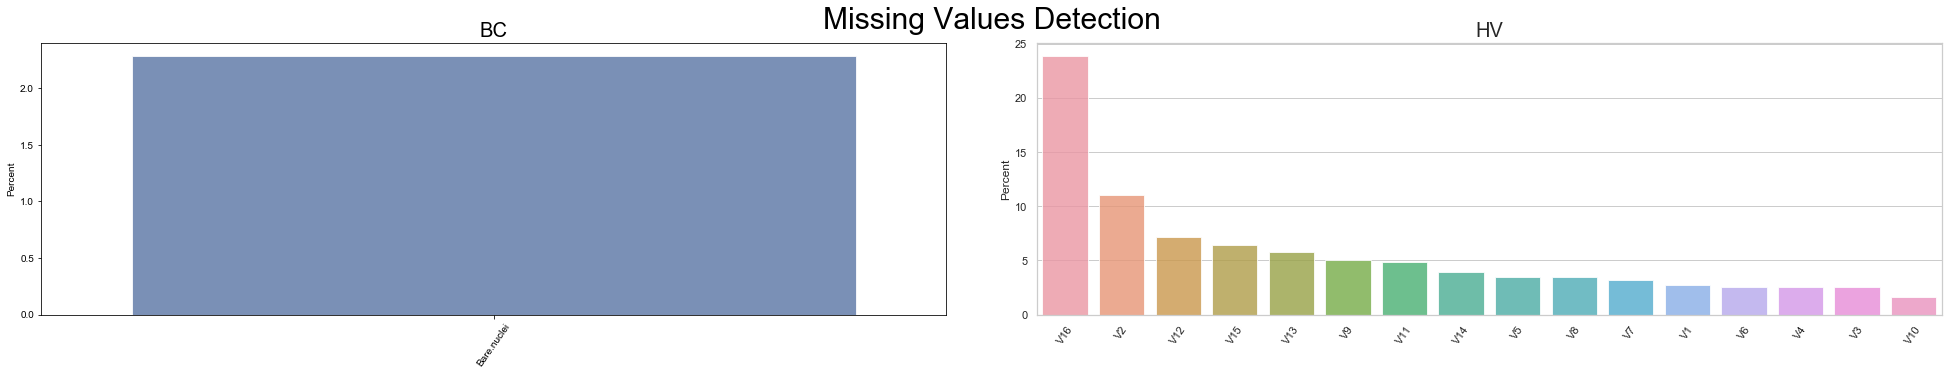

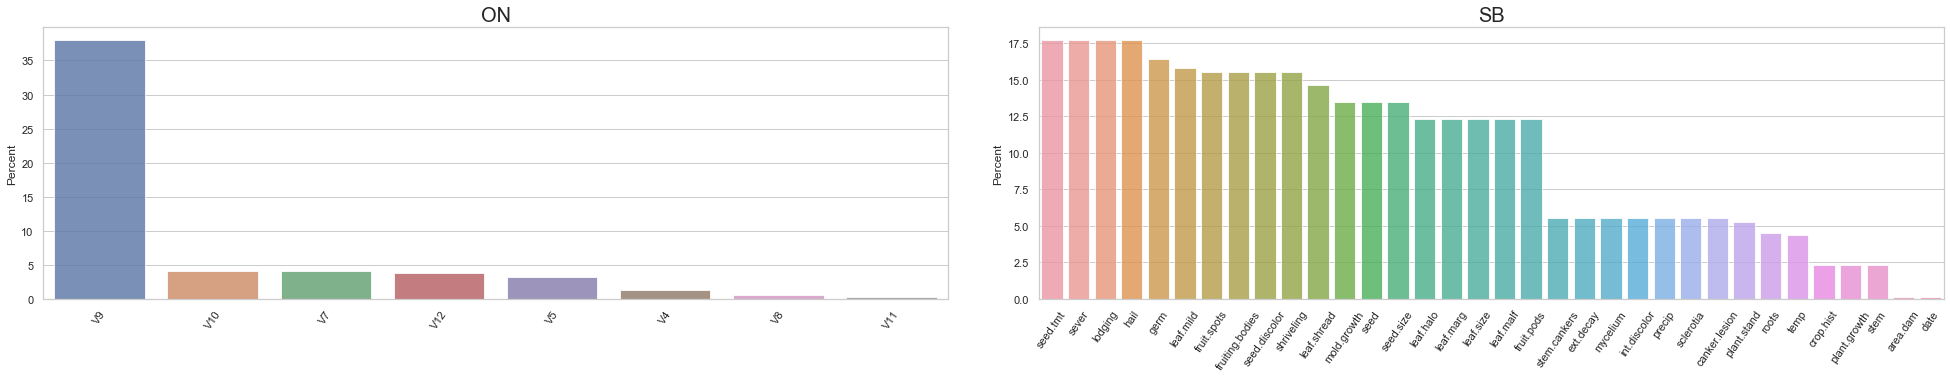

In [3]:
# create list with all 15 dataframes
data_15_list = []
# call class for cleaning datasets
cleaner = clean_data()
# bh dataframe
bh_df = cleaner.BH_df()
data_15_list.append(bh_df)
# plot missing value hist for bc dataframe
plt.figure(1, figsize=(33,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.subplots_adjust(left= 0.1, hspace=5, wspace=0.1)
plt.suptitle('Missing Values Detection', fontsize= 30)
plt.subplot(1, 2, 1)
# bc dataframe
bc_df = cleaner.BC_df()
data_15_list.append(bc_df)
# dn dataframe
dn_df = cleaner.DN_df()
data_15_list.append(dn_df)
# gl dataframe
gl_df = cleaner.GL_df()
data_15_list.append(gl_df)
# plot missing value hist for hv dataframe
plt.subplot(1, 2, 2)
hv_df = cleaner.HV_df()
data_15_list.append(hv_df)
plt.show()
# is dataframe
is_df = cleaner.IS_df()
data_15_list.append(is_df)
# plot missing value hist for on dataframe 
plt.figure(1, figsize=(33,5))
plt.gca().set_aspect('equal', adjustable='datalim')
plt.subplots_adjust(left= 0.1, hspace=5, wspace=0.1)
plt.subplot(1, 2, 1)
# on dataframe
on_df = cleaner.ON_df()
data_15_list.append(on_df)
# sl dataframe
sl_df = cleaner.SL_df()
data_15_list.append(sl_df)
# sr dataframe
sr_df = cleaner.SR_df()
data_15_list.append(sr_df)
# st dataframe
st_df = cleaner.ST_df()
data_15_list.append(st_df)
# sn dataframe
sn_df = cleaner.SN_df()
data_15_list.append(sn_df)
# plot missing value hist for sb dataframe
plt.subplot(1, 2, 2)
# sb dataframe
sb_df = cleaner.SB_df()
data_15_list.append(sb_df)
plt.show()
# vc dataframe
vc_df = cleaner.VC_df()
data_15_list.append(vc_df)
# wc dataframe
vw_df = cleaner.VW_df()
data_15_list.append(vw_df)
# zo dataframe
zo_df = cleaner.ZO_df()
data_15_list.append(zo_df)


In [4]:
class missingness(object):
    '''
    CLASS missingness()
    
    Inputs:
    
        - cleaned df;
        
        - missingness threshold.
        
    It induces missingness to input dataframe, in 4 different ways. It starts appending a uniform random vector as new column of the df, with values in [0,1].
    
    Then it induces uniform MCAR, random MCAR, uniform MNAR or random MNAR missingness to the df, based on the values of the initial uniform random vector.   
    '''
    
    def __init__(self, df, th=0.20):
        # cleaned dataset
        self.df = df
        # set missingness proportion
        self.th = th
        # random uniform vector with values in [0,1], length = n obs.
        self.vector_1 = np.random.uniform(0,1,len(self.df))
        # number of features
        self.n_attributes = len(self.df.columns)
        # list of feature indeces
        self.attr_idx = [i for i in range(self.n_attributes)]
        
    @staticmethod   
    def _func_righe(riga):
        #print(riga)
        if riga[-1] <= 0.2:
            riga_idx = [i for i in range(len(riga)-1)]
            half_attr = np.random.choice(riga_idx, size =(len(riga)//2),replace= False)
            riga[half_attr] = np.nan
        return riga
        
    def _MCAR_uniform(self):
        '''
        Returns:
        
            - df with induced uniform mcar missingness.
        '''
        df_mcar_uni = self.df.copy()
        ### MCAR uniform 
        # initialize col with random uniform vector
        df_mcar_uni['MCAR uniform'] = self.vector_1
        # set values of feature under threshold to nan
        df_mcar_uni.loc[df_mcar_uni['MCAR uniform'] <= self.th] = np.nan
        df_mcar_uni.drop('MCAR uniform', axis=1, inplace=True)
        return df_mcar_uni
    
    
    def _MCAR_random(self):
        '''
        Returns:
        
            - df with induced random mcar missingness.
        '''
        df_mcar_rand = self.df.copy()
        ### MCAR random
        # initialize col with random uniform vector
        df_mcar_rand['MCAR random'] = self.vector_1
        # set values of selected features to nan in correspondence of values under th
        #df_mcar_rand.iloc[:, half_attr][df_mcar_rand['MCAR random']<=self.th] = np.nan
        #sub_df = df_mcar_rand[df_mcar_rand['MCAR random']<=self.th]
        df_mcar_rand=df_mcar_rand.apply(lambda x: missingness._func_righe(x), axis=1)
        df_mcar_rand.drop('MCAR random', axis=1, inplace=True)
        return df_mcar_rand

    
    def _MNAR_uniform(self):
        '''
        Returns:
        
            - df with induced uniform mnar missingness.
        '''        
        df_mnar_uni = self.df.copy()
        ### MNAR uniform 
        # initialize col with random uniform vector
        df_mnar_uni['MNAR uniform'] = self.vector_1
        # pick 2 random attributes
        attr_2_idx = np.random.choice(self.attr_idx, size = 2, replace=False)
        # compute medians of the 2 columns related to the 2 random indeces
        median_1 = df_mnar_uni.iloc[:,attr_2_idx[0]].median()
        median_2 = df_mnar_uni.iloc[:, attr_2_idx[1]].median()
        #print(median_1, median_2)
        # 2 columns names  
        col_1 = self.df.columns[attr_2_idx[0]]
        col_2 = self.df.columns[attr_2_idx[1]]
        # all the features are converted to nan if to them correspond:
        # value of vector_1 <= threshold 
        # and one or both the 2 random features under the corresponding median.
        df_mnar_uni.loc[(((df_mnar_uni[col_1]<= median_1) | (df_mnar_uni[col_2] >= median_2)) & (df_mnar_uni['MNAR uniform'] <=self.th))] = np.nan
        df_mnar_uni.drop('MNAR uniform', axis=1, inplace=True)
        return df_mnar_uni
   
    def _MNAR_random(self):
        '''
        Returns:
        
            - df with induced random mnar missingness.
        '''     
        df_mnar_rand = self.df.copy()
        ### MNAR random 
        # initialize col with random uniform vector
        df_mnar_rand['MNAR random'] = self.vector_1
        # pick 2 random attributes from the original dataframe
        attr_2_idx = np.random.choice(self.attr_idx, size = 2, replace=False)
        # compute medians of the 2 columns related to the 2 random indeces
        median_1 = df_mnar_rand.iloc[:,attr_2_idx[0]].median()
        median_2 = df_mnar_rand.iloc[:, attr_2_idx[1]].median()
        #print(median_1, median_2)
        # 2 columns names of the original dataframe 
        col_1 = self.df.columns[attr_2_idx[0]]
        col_2 = self.df.columns[attr_2_idx[1]]
        # random half sample of feature indeces
        half_attr = np.random.choice(self.attr_idx, size =self.n_attributes//2,replace= False)
        half_names = self.df.columns[half_attr]
        # all the features are converted to nan if to them correspond:
        # value of vector_1 <= threshold 
        # and one or both the 2 random features under the corresponding median.
        df_mnar_rand.loc[(((df_mnar_rand[col_1]<= median_1) | (df_mnar_rand[col_2] >= median_2)) & (df_mnar_rand['MNAR random'] <=self.th)), half_names] = np.nan
        df_mnar_rand.drop('MNAR random', axis=1, inplace=True)
        return df_mnar_rand
    
    def apply_missingness(self, i):
        '''
        Returns:
        
            - list of tuples: each tuples contains df target index and one of the 4 corrupted datasets.
        '''
        df_mcar_uni = self._MCAR_uniform()
        df_mcar_rand = self._MCAR_random()
        df_mnar_uni = self._MNAR_uniform()
        df_mnar_rand = self._MNAR_random()
        return (i,df_mcar_uni), (i,df_mcar_rand), (i,df_mnar_uni), (i,df_mnar_rand)
    

In [5]:
i = 0
# initialize list for the 60 datasets
data_60_list = []
# list of call class
call = []
# for each of the 15 datasets
for df in data_15_list:
    # call class
    call.append(missingness(df, 0.20))
    # append the 4 corrupted datasets
    data_60_list.append(call[i].apply_missingness(i))
    # increment index
    i+=1
# flattening list: obtain a list of tuples (target idx, corrupted df)
data_60_list = [item for sublist in data_60_list for item in sublist]

In [6]:
class Autoencoder(tf.keras.Model):
    '''
    CLASS Autoencoder()
    
    daughter class of tf.keras.Model, in which autoencoder model is built.
    
    Inputs:
        - n: number of features;
        
        - theta: increasing dimensionality parameter.
    '''
    def __init__(self, n, theta):
        # my class inherits all methods of its parent class
        super().__init__()
        self.theta = theta
        # random uniform weights intialization
        self.kern_in = tf.random_uniform_initializer()
        self.drop = Dropout(0.5)
        self.h1 = Dense(n + self.theta, activation='tanh', kernel_initializer=self.kern_in)
        self.h2 = Dense(n + 2 * self.theta, activation='tanh', kernel_initializer=self.kern_in)
        self.h3 = Dense(n + 3 * self.theta, activation='tanh', kernel_initializer=self.kern_in)
        self.h4 = Dense(n + 2 * self.theta, activation='tanh', kernel_initializer=self.kern_in)
        self.h5 = Dense(n + self.theta, activation='tanh', kernel_initializer=self.kern_in)
        self.out = Dense(n, activation='tanh', kernel_initializer=self.kern_in)

    def call(self, x, train_drop = True):
        '''
        Inputs:
            - x: input;
            
            - train_drop: boolean indicating whether the layer should behave in training mode (adding dropout) or in inference mode (doing nothing).
            
        Returns:
        
            - model output. 
        '''
        # drop layers adding call arguments
        x = self.drop(x, training=train_drop)
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        return self.out(x)
    
    def infer(self, x):
        x = self.h1(x)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        return self.out(x)



class model(object):
    '''
    CLASS model()
    
    Takes in input:
    
        - corrupted df (dataframe with original na filled, and with added missingness (MCAR uni or random or MNAR uni or random));
        
        - target df (original dataframe with filled na);
        
        - parameter of dimansionality increasing among layers, theta.
        
    The class consists in building the denoising autoencoder DAE, training and testing it using data. 
    '''
    def __init__(self,corrupted_df,target_df,theta=7):
        self.df_corrupted = corrupted_df
        self.df_target = target_df
        self.theta = theta
        # features
        self.n = len(self.df_corrupted.columns)

    def _autoencoder(self):
        model = Autoencoder(self.n, self.theta)
        return model
    
    def split_data(self):
        '''
        Returns:
        
            - X_train: 70% of corrupted df used to train model;
            
            - X_test: 30% of corrupted df used to evaluate model;
            
            - target_train: 70% of target df used to train model;
            
            - target_test: 30% of target df used to evaluate model.
        '''
        net = self._autoencoder()
        # model can't take in input nan values
        # so fillna with 0
        #self.df_corrupted.fillna(-1, inplace = True)
        # scale data
        scaler = MinMaxScaler()
        #X = self.df_corrupted.to_numpy()
        #print(self.df_corrupted.iloc[0])
        #print(self.df_corrupted.to_numpy()[0])
        print(self.df_corrupted)
        X = scaler.fit_transform(self.df_corrupted.to_numpy())
        X = np.nan_to_num(X, nan = 0)
        
        #target = self.df_target.to_numpy()
        target = scaler.fit_transform(self.df_target.to_numpy())
        #target = X
        # split data
        X_train, X_test, target_train, target_test = model_selection.train_test_split(X, target, train_size = 0.70, test_size = 0.30)
        return X_train, target_test, target_train, target_test
        #return X_train, X_test, target_train, target_test
    
    def train_test(self, dataset_name, imputation):
        '''
        Returns:
        
            - rmse value as result of the model training and evaluation.
        '''
        # nn
        net = self._autoencoder()
        #net.summary()
        # splitted data
        X_train, X_test, target_train, target_test = self.split_data()
        # SGD nesterov accelerated gradient 
        #optimizer = optimizers.SGD(nesterov=True, decay = 0.99)
        #optimizer = optimizers.Adam()
        optimizer = optimizers.Nadam(learning_rate=1e-3, decay=0.99)
        loss_fn = losses.MeanSquaredError()
        
        train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
        
        # RMSE
        # initialize array of rmse
        metrics_array = [metrics.RootMeanSquaredError() for i in range(self.n)]
    
        
        # Prepare the training and test dataset.
        batch_size = 500
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, target_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, target_test))
        test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)       
        
        # tb    
        try:
            shutil.rmtree('logs/gradient_tape/' + 'prova_'+imputation)
        except:
            pass
        
        train_log_dir = 'logs/gradient_tape/' + 'prova_'+imputation + '/train'
        test_log_dir = 'logs/gradient_tape/'+ 'prova_' + imputation + '/test'
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        test_summary_writer = tf.summary.create_file_writer(test_log_dir)
        
        
        
        epochs = 500
        losses_list = []
        sma = []
        for epoch in range(epochs):
            #print('Start of epoch %d' % (epoch,))
            # TRAIN
            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

                # Open a GradientTape to record the operations run
                # during the forward pass, which enables autodifferentiation.
                with tf.GradientTape() as tape:

                    # Run the forward pass of the layer.
                    # The operations that the layer applies
                    # to its inputs are going to be recorded
                    # on the GradientTape.
                    logits = net(x_batch_train, training=True)  # Logits for this minibatch

                    # Compute the loss value for this minibatch.
                    loss_value = loss_fn(y_batch_train, logits)
                    train_loss(loss_value)
                    
                    ### early stopping 0
                    '''
                    if len(losses_list)!=0 and loss_value > losses_list[-1]:
                        string0 = 'min loss before its reincreasing'
                        return string0
                    '''
                    losses_list.append(loss_value)
                    
                    ### early stopping 1
                    # terminate training if desired mse is achieved
                    if loss_value <= 1e-06:
                        string1 = 'mse of 1e-06 is achieved'
                        return string1
                    
                    ### early stopping 2
                    string2 = 'sma of error deviance does not improve'
                    current_idx = len(losses_list)-1
                    s = 0
                    if len(sma) != 0 and len(losses_list)>= 5:
                        for i in range(current_idx, current_idx-5, -1):
                            s += losses_list[i]
                        simple_moving_avg = s/5
                        if simple_moving_avg == sma[-1]:
                            return string2
                        sma.append(simple_moving_avg)
                    
                # tb  
                with train_summary_writer.as_default():
                    tf.summary.scalar('loss', train_loss.result(), step=epoch)
                    

                
                # concatenate batches (Accumulates root mean squared error statistics)
                #for i, metrica in enumerate(metrics_array):
                    #metrica(tf.transpose(y_batch_train)[i], tf.transpose(logits)[i])
                    
                    
                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, net.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, net.trainable_weights))
                
            
                
            # TEST
            for x_batch_test, y_batch_test in test_dataset:
                test_logits = net.infer(x_batch_test)
                loss_value = loss_fn(y_batch_test, test_logits)
                test_loss(loss_value)
                # concatenate batches (Accumulates root mean squared error statistics)
                for i, metrica in enumerate(metrics_array):
                    metrica(tf.transpose(y_batch_test)[i], tf.transpose(test_logits)[i])
        
            test_results = [elem.result() for elem in metrics_array]
            # tb
            with test_summary_writer.as_default():
                tf.summary.scalar('loss', test_loss.result(), step=epoch)
                
            
            
        
        
       
            # reset metrics at the end of each epoch  
            train_loss.reset_states()
            test_loss.reset_states()
            for i in metrics_array:
                i.reset_states()
                
        # Display metric at the end of each epoch.   
        print('Test RMSE: %f' % sum(test_results))
    
        return sum(test_results)

In [7]:
# prova su un df

corr_df = data_60_list[0][1]
t_df = data_15_list[0]
m = model(corr_df, t_df)


m.train_test('prova', '1')


        crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
1    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
2    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
3    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
4    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
5    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
502  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
503  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
504  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
505      NaN   NaN    NaN   NaN    NaN    NaN   NaN     NaN  NaN    NaN   
506      NaN   NaN    NaN   NaN    NaN    NaN   NaN     NaN  NaN    NaN   

     ptratio       b  lstat  medv  
1       15.3  396.90   4.98  24.0  
2       17.8  396.90   9.14

<tf.Tensor: id=474200, shape=(), dtype=float32, numpy=2.424719>

In [8]:
# prova su un df

corr_df = data_60_list[1][1]
t_df = data_15_list[0]
m = model(corr_df, t_df)


m.train_test('prova', '5')


        crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
1    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
2    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
3    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
4    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
5    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
502  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
503  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
504  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
505      NaN   0.0  11.93   NaN  0.573  6.794   NaN  2.3889  NaN    NaN   
506      NaN   0.0  11.93   0.0    NaN    NaN  80.8     NaN  1.0  273.0   

     ptratio       b  lstat  medv  
1       15.3  396.90   4.98  24.0  
2       17.8  396.90   9.14

<tf.Tensor: id=948398, shape=(), dtype=float32, numpy=2.4961686>